<a href="https://colab.research.google.com/github/oscarB1nar10/NLP/blob/main/gpt_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
!wget https://www.gutenberg.org/files/2000/2000-0.txt

--2024-09-17 11:31:14--  https://www.gutenberg.org/files/2000/2000-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2226045 (2.1M) [text/plain]
Saving to: ‘2000-0.txt’

2000-0.txt          100%[===================>]   2.12M  1.35MB/s    in 1.6s    

2024-09-17 11:31:17 (1.35 MB/s) - ‘2000-0.txt’ saved [2226045/2226045]



In [ ]:
with open('2000-0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  2130398


In [ ]:
# Let's look at the first 1000 characters
print(text[:1000])

﻿The Project Gutenberg eBook of Don Quijote, by Miguel de Cervantes Saavedra

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Don Quijote

Author: Miguel de Cervantes Saavedra

Release Date: December, 1999 [eBook #2000]
[Most recently updated: January 2, 2020]

Language: Spanish

Character set encoding: UTF-8

Produced by: an anonymous Project Gutenberg volunteer and Joaquin Cuenca Abela

*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***




El ingenioso hidalgo don Quijote de la Mancha



por Miguel de Cervantes Saavedra





El ingenioso hidalgo don Quijote de la Mancha


  
Tasa



In [ ]:
# All unique characters that occur in this text
position_start_of_story = text.find("El ingenioso hidalgo don Quijote de la Mancha")
text = text[position_start_of_story:]
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"$%'()*,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZ]abcdefghijklmnopqrstuvwxyz¡«»¿ÁÉÍÑÓÚàáéíïñóùúü—
102


In [ ]:
# Create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars)}
itos = { i:ch for i,ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s] # Encoder: Take a string and output a list of integers
decoder = lambda l: ''.join([itos[i] for i in l]) # Decoder: Take a list of integers and output a string

print(encode("hii there"))
print(decoder(encode("hii there")))
print(decoder([0]))
print(decoder([1]))
print(decoder([2]))
print(decoder([64]))

[62, 63, 63, 1, 74, 62, 59, 72, 59]
hii there


 
!
j


In [ ]:
# Let's encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:500])

torch.Size([2129542]) torch.int64
tensor([32, 66,  1, 63, 68, 61, 59, 68, 63, 69, 73, 69,  1, 62, 63, 58, 55, 66,
        61, 69,  1, 58, 69, 68,  1, 44, 75, 63, 64, 69, 74, 59,  1, 58, 59,  1,
        66, 55,  1, 40, 55, 68, 57, 62, 55,  0,  0,  0,  0, 70, 69, 72,  1, 40,
        63, 61, 75, 59, 66,  1, 58, 59,  1, 30, 59, 72, 76, 55, 68, 74, 59, 73,
         1, 46, 55, 55, 76, 59, 58, 72, 55,  0,  0,  0,  0,  0,  0, 32, 66,  1,
        63, 68, 61, 59, 68, 63, 69, 73, 69,  1, 62, 63, 58, 55, 66, 61, 69,  1,
        58, 69, 68,  1, 44, 75, 63, 64, 69, 74, 59,  1, 58, 59,  1, 66, 55,  1,
        40, 55, 68, 57, 62, 55,  0,  0,  0,  1,  1,  0, 47, 55, 73, 55,  0,  0,
         1,  1,  0, 47, 59, 73, 74, 63, 67, 69, 68, 63, 69,  1, 58, 59,  1, 66,
        55, 73,  1, 59, 72, 72, 55, 74, 55, 73,  0,  0,  1,  1,  0, 32, 66,  1,
        45, 59, 79,  0,  0,  1,  1,  0, 28, 66,  1, 31, 75, 71, 75, 59,  1, 58,
        59,  1, 29, 93, 64, 55, 72,  0,  0,  1,  1,  0, 43, 72, 97, 66, 69, 61,
      

In [ ]:
# Let's split up the data into train and validation sets
n = int(0.9*len(data)) # First 90% will be train, rest validation
train_data = data[:n]
val_data = data[n:]

In [ ]:
block_size = 8 # Context length: how many characters do we take to predict the next one
train_data[:block_size+1]

tensor([32, 66,  1, 63, 68, 61, 59, 68, 63])

In [ ]:
# The `y` is slided one position to the right
# i.e., X = [10, 12, 15, 28, 30], y = [12, 15, 28, 30, 40]
x = train_data[:block_size]
y = train_data[1:block_size+1]
print(f"x: {x[:]}, y: {y[:]}")

for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f"When input is {context} the target: {target}")

x: tensor([32, 66,  1, 63, 68, 61, 59, 68]), y: tensor([66,  1, 63, 68, 61, 59, 68, 63])
When input is tensor([32]) the target: 66
When input is tensor([32, 66]) the target: 1
When input is tensor([32, 66,  1]) the target: 63
When input is tensor([32, 66,  1, 63]) the target: 68
When input is tensor([32, 66,  1, 63, 68]) the target: 61
When input is tensor([32, 66,  1, 63, 68, 61]) the target: 59
When input is tensor([32, 66,  1, 63, 68, 61, 59]) the target: 68
When input is tensor([32, 66,  1, 63, 68, 61, 59, 68]) the target: 63


In [ ]:
torch.manual_seed(1337)
batch_size = 64 # How many independent sequences will be process in parallel
block_size = 264  # Maximun context lenght for predictions
max_iters = 5000
learning_rate = 1e-3
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_batch(split):
  # Generate a small batch of data of inputs x and tarjets y
  data = train_data if split=='train' else val_data
  # Generate random integers within a specified range. In this case the range is from 0 to `len(data)-block_size`
  ix = torch.randint(len(data)-block_size, (batch_size,)) # torch.Size([64])
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x, y

xb, yb = get_batch('train')
xb = xb.to(device)
yb = yb.to(device)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# for b in range(batch_size): # Batch dimension
#   for t in range(block_size): # Time dimension
#     context = xb[b, :t+1]
#     target = yb[b, t]
#     print(f'When input is {context.tolist()} the target: {target}')

inputs:
torch.Size([64, 264])
tensor([[58, 55, 72,  ...,  1, 74, 69],
        [55,  1, 55,  ..., 58, 69, 68],
        [58, 59, 73,  ..., 97, 24,  0],
        ...,
        [62, 55,  1,  ..., 75, 79, 69],
        [68,  1, 59,  ..., 75, 59,  1],
        [ 1, 59, 73,  ..., 72, 55, 59]], device='cuda:0')
targets:
torch.Size([64, 264])
tensor([[55, 72,  1,  ..., 74, 69, 58],
        [ 1, 55,  1,  ..., 69, 68,  1],
        [59, 73,  1,  ..., 24,  0,  0],
        ...,
        [55,  1, 59,  ..., 79, 69,  1],
        [ 1, 59, 68,  ..., 59,  1, 93],
        [59, 73,  1,  ..., 55, 59, 72]], device='cuda:0')
----


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F
torch.manual_seed(1337)

class Head(nn.Module):
  """ One head of self-attention """

  def __init__(self, head_size):
    super().__init__()
    # The input dimension `n_embd` for the linear/fully connected layer is tipically the size of the embeddings (or features)
    # that the model process.
    # Each of these layers thus performs a linear transformation y = W @ x, where `x` is the input tensor and `W` is the learned
    # weight matrix of the layer.
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer ('tril', torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    # `B` is the batch size
    # 'T` is the sequence lenght: Indicates the number of tokens (words or characters) in each sequence
    # `C` is the channels or feature dimension: Represents the size of the feature vector associated with each element of the sequence.
    # In NLP applications, this often corresponds to the embedding size.
    B,T,C = x.shape
    k = self.key(x) # (B,T,C)
    q = self.query(x) # (B,T,C)
    # Compute attention scores ("afinnities")
    wei = q @ k.transpose(-2, -1) * C**-.05 # (B,T,C) @ (B,C,T) -> (B,T,T)
    # Used to modify elements of `wei` based on a condition specified by a mask `tensor.masked_fill(mask, value)`
    # The purpose is to enforce causality within the attention mechanism, ensuring that the model cannot "look ahead"
    # to future positions in the sequence during training.
    # Each output should only depend on previous inputs and not on any future context.
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B,T,T)<------------------------------------------------------------------- key part of 1) Masked Multi-head Attention
    # Each row of the last dimension `(B, T_i, :)` represents the unnormalized attention scores computed between
    # a query at position `i` and all keys across the sequence. The Softmax function is applied to these scores to convert them
    # into a probability distribution over all sequence positions for each query.
    # Ensures that the scores are normalized across each set of keys for every individual query. This converts the raw attention scores into
    # probabilitites indicating the relative importance or contribution of each key to the query at position `i`
    wei = F.softmax(wei, dim=-1) # (B,T,T)
    wei = self.dropout(wei)
    # Perform the weighted aggregation of the values
    v = self.value(x) # (B,T,C)
    out = wei @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
    return out

class MultiHeadAttention(nn.Module):
  """ Multiple heads of self-attention in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    # This is a list of `Head` instances, each representing a single attention head.
    # Each head can potentially focus on different parts of the input allowing the model to capture various aspects of the input data
    # simultaniously
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    # When outputs from all heads are concatenated, where each head outputs `(B, T, head_size)`, the concatenated result for `num_heads` heads
    # will have shape `(B, T, num_heads*head_size)`
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    # This layer projects from `(B, T, num_heads * head_size)` back to `(B, T, n_embd)` restoring the original feature dimension while integrating
    # information from all attention heads.
    out = self.proj(out)
    return out


class FeedForward(nn.Module): # <--------------------------------------------------------------------------------- key part of 3) Feedforward
  """ A simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
     super().__init__()
     # Constructs a sequential container which represents a NN of two linear layers
     # First linear layer: This layer takes the input embeddings of dimension `n_embd` and projects them
     # to a higherdimensional space, specifically `4 * n_embd`
     # Second linear layer: The output of the `ReLU` activation function is then passed to this layer
     # which projects the data back down to the original embedding dimension `n_embd`
     self.net = nn.Sequential(
         nn.Linear(n_embd, 4 * n_embd),
         nn.ReLU(),
         nn.Linear(4 * n_embd, n_embd),
         nn.Dropout(dropout),
     )

  def forward(self, x):
     return self.net(x)


class Block(nn.Module):
  """ Transformer block: communication followed by computation """

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension, n_head: the number of attention heads in the multi-head attention mechanism
    # `head_size`: represents the dimensionality of each attention head. Dividing the embedding dimension by the number of heads
    # splits the model's focus across multiple "perspectives" or "views" of the input.
    # The `head_size` essentially dictates how many features each head in the multi-head attention mechanism can consider.
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    # LayerNorm(ln1 and ln2): Normalization layers that stabilize the training of deep neural networks.
    # They normalize the inputs across the features for each sample separately and are applied before before
    # the attention and feedforward operations.
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    # LayerNorm: Before passing the input `x` to the self-attention module, it is normalized by `ln1`.
    # Self-Attention with Residual Connection: The self-attention mechanism `sa` processes the normalized input. The result is added back
    # to the original input `x` (this is the "residual connection").
    # Second Layer Normalization: The result of the first layer + self-attention is then normalized again by `ln2` before being passed to the
    # feedforward network.
    # Feedforward with Residual Connection: The feedforward network processes the second normalized result, and again, the output is added to
    # the input of the feedforward network (another residual connection)
    x = x + self.sa(self.ln1(x))# <--------------------------------------------------------------------------------------------------------- key part 2) Add and Norm
    x = x + self.ffwd(self.ln2(x))
    return x

class FixedSinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embedding_length, sequence_length=5000):
        super().__init__()
        positional_encoding = torch.zeros((sequence_length, embedding_length))
        # One column of positions from 0 to 'sequence_length'
        position = np.arange(0, sequence_length).reshape(-1, 1)
        # Computes the divisor term for the positional encoding formula
        div_term = np.exp(np.arange(0, embedding_length, 2) * -(np.log(10000.0) / embedding_length))

        # Applies the sine function to even indices and converts to a tensor before assigning
        positional_encoding[:, 0::2] = torch.tensor(np.sin(position * div_term), dtype=torch.float32)
        # Applies the cosine function to odd indices and converts to a tensor before assigning
        positional_encoding[:, 1::2] = torch.tensor(np.cos(position * div_term), dtype=torch.float32)

        # Converts the tensor 'positional_encoding' into a PyTorch tensor and adds a dimension at the start to make it compatible
        # with batch processing. This tensor now has a shape of (1, sequence_length, embedding_length)
        self.positional_encoding = positional_encoding.unsqueeze(0)

    def forward(self, x):
        # Adds positional encoding to the input tensor 'x'
        x = x + self.positional_encoding[:, :x.size(1), :].to(x.device)
        return x


class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Each token directly reads off the logits for the next token from a lookup table
        # This layer converts token indices into dense vectors of fixed size (`n_embd`). It serves as the basic representation
        # of tokens before they are processed by the transformer blocks
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # Since the transformer architecture does not inherently process sequential data (i.e., it does not have a notion of "order" or
        # "position"), position embeddings are added to give the model some information about the position of tokens in the sequence.
        self.postion_embedding_table = nn.Embedding(block_size, n_embd) # Learned parameters approach
        #self.postion_embedding = FixedSinusoidalPositionalEmbedding(embedding_length = n_embd, sequence_length = block_size)
        # A series of Transformer blocks (`Block`), each consisting of multi-head self-attention and a feed-forward network. These blocks
        # process the input embeddings sequentially, refining and transforming the representations.
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        # Layer Normalization: Applied to the output of the last Transformer block to stabilize the training process.
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        # Ouput Linear Layer: Projects the output of the transformer block to the vocabulary size, providing a logit for each token
        # in the vocabulary which will be used to predict the next token.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        # Token embeddings are retrived for each index in `idx`, and position embeddings are generated for each position in the sequence.
        # These embeddings are then summed to produce the initial set of embeddings for each token, incorporating both its intrinsic meaning
        # and its position in the sequence.
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        #x = self.postion_embedding(tok_emb) # (B,T,C), with sinusoidal positional encoding
        # The following two lines work with position encodding with learned parameters
        pos_emb = self.postion_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # The combined embeddings are then processed through the sequence of Transformer blocks
        x = self.blocks(x) # Apply one head of self-attention. (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size) # <--------------------------------------------------------------------------------------------- key part 4) Linear

        # if `targets` is provided (indicating that this is a training pass), the crossentropy loss between the logits and
        # the tagets is computed. This loss measures the model's accuracy in predicting the next token.
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # Used for generating text by autoregressively predicting one token at a time, based on a given starting context (`idx`)
    def generate(self, idx, max_new_tokens):
        # `idx` is a tensor of shape `(B, T)`, where `B` is the batch size (number of sequences being generated simultaneously)
        # and `T` is the initial number of tokens provided as context
        for _ in range(max_new_tokens):
            # Ensures that only the last `block_size` tokens are used as a context
            # In sequence generation, particularly in language models, the most immediate context (i.e., the most recent words or tokens)
            # is usually the most indicative of what should logically and coherently come next. By focusing on the last `block_size`
            # tokens, the model is made to consider the most recent context, which is more likely to influence the immediate next
            # token in a meaningful way
            idx_cond = idx[:, -block_size:]
            # The model predicts the logits for the next token based on the current context (`idx_cond`)
            logits, loss = self(idx_cond)
            # After processing the input sequence through the model, the prediction for the next new token, based on the entire input sequence
            # is contained in the logits corresponding to the last position in the sequence.
            # Therefore, the last position in the sequence predicts the token that follows the entire current sequence.
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # Converts the logits to probabilitites using the Softmax function, which normalizes the logits into a probability distribution
            # over all possible next tokens in the vocabulary.
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C) <------------------------------------------------------------------------------- key part 5) Softmax
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel()
m = m.to(device)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decoder(m.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)[0].tolist()))

torch.Size([16896, 102])
tensor(5.0422, device='cuda:0', grad_fn=<NllLossBackward0>)

3ú/aWÚa;'x t2ÁÚ6t0—Íxó/AL%$LrI8Oc—»»aUBíWs25J)ù)»qcR%*Ñi"*Ñ5Ñz]XdL(xóúTiJóq¿4«ayùrr«cT%
K:Óo;I'g5c«ù


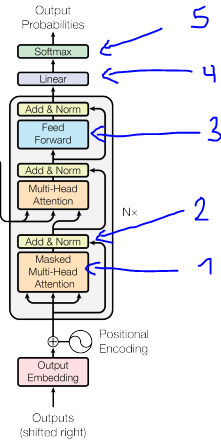
#### In the transformer architecture, each layer or block consist of two main components:

#### 1. Multi-Head Attention: Which process the input data in parallel through multiple attention heads to capture different aspects of the input data at different positions.

#### 2. Position-wise Feed-Forward Network: After the Muti-Head Attention agregates and transforms the input data, this feeedforward network is applied independently to each position of the input sequence. It further transforms the data to help the model capture complex dependencies not captured by the attention mechanism.

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

### Train the model

In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
# Add scheduler
scheduler = StepLR(optimizer, step_size=32, gamma=0.0001)

In [ ]:
#batch_size = 32
loss_values = [] # List to store the loss values
for steps in range(max_iters):

  # Sample a batch of data
  xb, yb = get_batch('train')
  xb = xb.to(device)
  yb = yb.to(device)

  # Evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  # Step the scheduler
  scheduler.step()

  loss_values.append(loss.item())

  print(loss.item())


5.042168617248535
10.558672904968262
8.826519012451172
8.130725860595703
7.226641654968262
6.124982833862305
5.312165260314941
4.376918315887451
3.7212414741516113
3.475322723388672
3.0469744205474854
3.0939321517944336
2.993593692779541
2.908982992172241
2.838670492172241
2.7321977615356445
2.7356741428375244
2.78070068359375
2.6842193603515625
2.629721164703369
2.6330296993255615
2.6110925674438477
2.581397533416748
2.5586280822753906
2.5785694122314453
2.5426602363586426
2.5166823863983154
2.507244110107422
2.500839948654175
2.4988772869110107
2.4934701919555664
2.492265462875366
2.4624667167663574
2.4574077129364014
2.479788303375244
2.4750914573669434
2.456813097000122
2.4512081146240234
2.480785846710205
2.470933198928833
2.456944704055786
2.48120379447937
2.4787580966949463
2.474381923675537
2.4607205390930176
2.4881608486175537
2.463122606277466
2.4489617347717285
2.4821860790252686
2.4646897315979004
2.4672324657440186
2.4882657527923584
2.4676506519317627
2.470757007598877
2.

In [ ]:
print(decoder(m.generate(idx=torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=1000)[0].tolist()))


lejóoso,a ya, s poncid—é, azséare ta pas.o, splsdata  nnc p ¿e—edladann pquees, y eon masasplllls plll any c,eststó s hon stsa,orosepicodaeta l dím, medips, a yo sau toe p qu s l
els dadimos mido yo, pl He uo ss l ls a sos quij lldosenciabea atada es y us cadide Aasa p sdo pó spal, mp petdtpsquidospes a mi l cas c huia qumalen siis paelo y pa asecodies s pas a cela d luec pssss easotap la lo, ts, Qteue t hsts rs,e s  didmpos cijs v A chblap ta, a peci, qu qu—achquéan last ms ecadospstalidias Nades-e qubtdos mampaO s ts pas —d s
di es dests
acdo Sae p Do e cass, Pssazell s, pu, dos lcale he tn mu po l»s y l dooyoeagsuc pscasdtacsY alze p, liama puelas dsotela ma, o, ys c lesi, land ses cha ael, s qudostes  halar yy, q s en pa, e ¡pooa  Ee.sen cqu s»len das co pa c ya quc mps ispo pdos epa m e pe Hmpdo pocisues ll po l payascallased ulapas me qu mpepUsqudpe pa mp no, maados, p s cs s Q;e yoy c p h — to psc y le pa dies ds Yseve éó pazlssp D sr pus Nsue  psacidosmpiüa e s
uia cass can l 

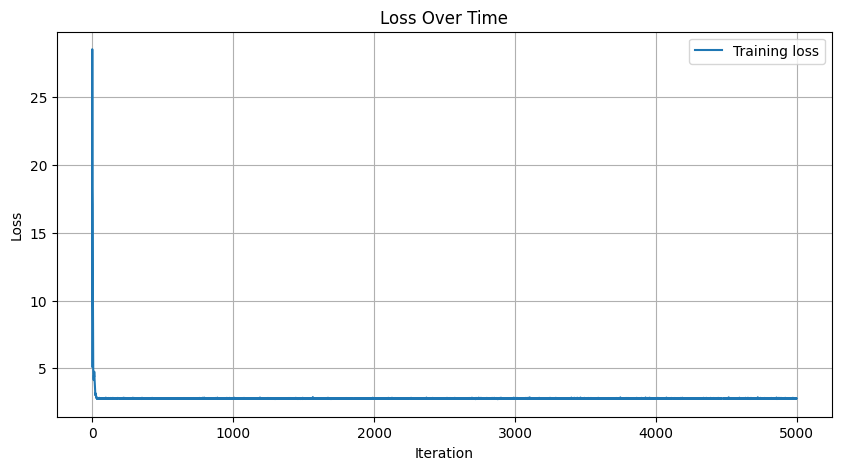

In [ ]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training loss')
plt.title('Loss Over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### The mathematical trick is self-attention

In [ ]:
# Consider the following toy example
# We want that the tokens talk to each other but in a specific way (backward).
# For instance a token in the fifth location it should not communicate with token in the sixth, seventh and eight location
# because those are future tokens in the sequence instead should only talk to the fourth, third, second and one

# A week way of communication between the token is through averagin the influence of the previous token to the current one

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# The trick is that we can be very efficient about doing this
# using matrix multiplication. Thats the mathematical trick
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

False

In [ ]:
xbow[0], xbow2[0]

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

In [ ]:
# We can do weighted aggregations of the past elements by using matrix multiplication of a lower triangular
# matrix. The elements in the triangula matrix are telling us how much each element fuses
# Version 3: Use Softmax
trill = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
# For all the elements where trill is equals to 0 make them negative infinity
# The future tokens can't communicate with the past tokens
wei = wei.masked_fill(trill == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

False

In [ ]:
# Gather information from the past in a data dependent way. This is the problem that self-attention solves.
# Now, the way self-attention solves this is the following:
# Every single node (token) at each position will emit two vectors (query, key).
# The query vector roughly speaking is what we are looking for.
# The key vector roughly speaking is what do we contain.
# The way how we get affinities between these tokens now in a sequence is doing dot product between the keys and the queries.
# So our query dot product with all the keys of all the other tokens and that dot product now becomes `wei`.
# If the key and the query are sort aligned they will interact to a very high amount and then we will get to learn more about that
# specific token as opposed to any othe token in the sequence.

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# Let's see a single head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)


trill = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(trill == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
out.shape

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
# By manipulating these elements of the multiplying matrix and then multiplying it with any given matrix
# we can do these averages in this incremental fashion

torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print(a)
print(b)
print(c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])
